In [207]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import sys
import os

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_7924\1517835734.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [208]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [209]:
os.environ['TORCH_HOME'] = './'

In [210]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(), #scale image to be between ZERO & ONE
    #min value = (0 - mean 0.5) / std 0.5 = -1
    #max value = (1 - mean 0.5) / std 0.5 = 1
    T.Normalize(
        mean=[0.5,0.5,0.5],
        std =[0.5,0.5,0.5]
        ),  
    T.Resize(64)
    #T.RandomHorizontalFlip(p=0.5)
])

In [211]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.CIFAR10(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)

Files already downloaded and verified


In [212]:
print(train_data.data.shape)

(50000, 32, 32, 3)


In [213]:
# Step 4: Translate into dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [214]:
# unique class categories
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [215]:
X, y = next(iter(train_loader))
print(X.data.shape)

# for i in range(32):
#     ax = plt.subplot(4,8, i+1)
#     plt.imshow(imgs[i].squeeze().reshape(32,32), cmap='magma')
#     plt.xticks([])
#     plt.yticks([])

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([128, 3, 64, 64])


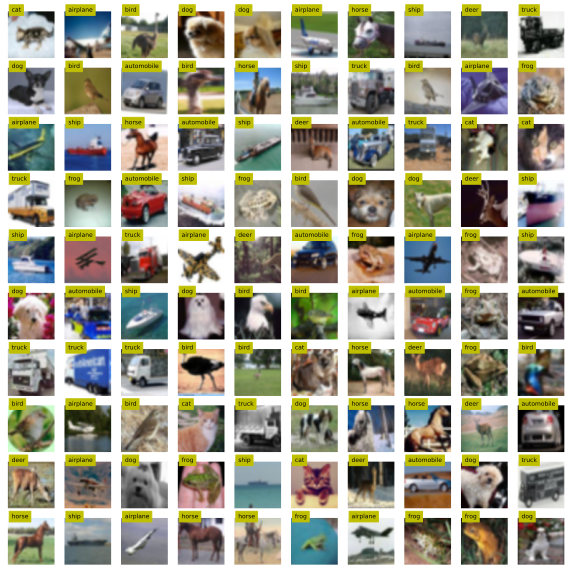

In [216]:
# check for a few random images
fix, axs = plt.subplots(10,10,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    #extract the image (transpose it back to 32x32x3) so matplot can understand it
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + 0.5 #undo normalization
    
    label = train_data.classes[y[i]]
    
    ax.imshow(pic)
    ax.text(5,0, label, ha='left', color='k', backgroundcolor='y', fontsize=6) #fontweight='bold'
    ax.axis('off')



In [313]:

# 1   -> 64  -> leaky_relu 0.2 =>
# 64  -> 128 -> leaky_relu 0.2 -> bn =>
# 128 -> 256 -> leaky_relu 0.2 -> bn => 
# 256 -> 512 -> leaky_relu 0.2 -> bn =>
# 512 -> 1   -> sigmoid

# 32 -> 16 -> 8 -> 4 -> 1
class discriminatorModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        inChans  = 3 # RGB # NUMBER OF CHANNELS => latent space of 64
        outChans = 64 # feature maps # of kernels # optional number
        krnSize  = 4 # odd number
        stride   = 2 # use maxpool instead of stride ... so stride = 1
        padding  = 1 # square if single input
    
        # First Convolution Layer
        #Conv2d(in_channels # of channels,
        #       out_channels # feature maps kernels, 
        #       kernel_size, 
        #       stride,
        #       padding  )
        self.conv1  = nn.Conv2d(inChans,outChans,krnSize, stride, padding, bias=False) #1<>64
        # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride ) + 1
        # output size = floor( (64 + 2*1 - 4) / 2 ) + 1 = 32
        
        # Second Convolution Layer
        self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, stride, padding, bias=False) #64<>128
        self.bn2    = nn.BatchNorm2d(128)
        # output size = floor( (32 + 2*1 - 4) / 2 ) + 1 = 16

        # Third Convolution Layer
        self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding, bias=False) #128<>256
        self.bn3    = nn.BatchNorm2d(256)
        # output size = floor( (16 + 2*1 - 4) / 2 ) + 1 = 8

        self.conv4  = nn.Conv2d(outChans*2*2,outChans*2*2*2,krnSize, stride, padding, bias=False) #256<>512
        self.bn4    = nn.BatchNorm2d(512)
        # output size = floor( (8 + 2*1 - 4) / 2 ) + 1 = 4


        self.conv5  = nn.Conv2d(outChans*2*2*2,1,kernel_size=4, stride=1, padding=0, bias=False) #512<>1 #1 = real or fake
        # output size = floor( (4 + 2*0 - 4) / 1 ) + 1 = 1
        
    def forward(self,x):
        #first conv -> maxpool -> batchnorm -> relu
        #CPBR block
        print(f'X BASE {x.shape}')
        x = F.leaky_relu( self.conv1(x), 0.2  )
        print(f'conv1 {x.shape}')
        
        x = F.leaky_relu( self.conv2(x), 0.2  )
        x = self.bn2(x)
        print(f'conv2 {x.shape}')
        
        x = F.leaky_relu( self.conv3(x), 0.2  )
        x = self.bn3(x)
        print(f'conv3 {x.shape}')

        x = F.leaky_relu( self.conv4(x), 0.2   )
        x = self.bn4(x)
        print(f'conv4 {x.shape}')
        
        x = self.conv5(x)
        print(f'conv5 {x.shape}')
        
        x = torch.sigmoid( x ).view(-1,1)
        print(f'view -1,1 {x.shape}')
        #(-1,1)=>(batch_size, 1).
        #Before `.view(-1, 1)`: [128, 1, 1, 1] (example shape from conv output)
        #After  `.view(-1, 1)`: [128, 1]
        return x

In [314]:
# discriminator model instance
discrModel = discriminatorModel().to(device)

In [316]:
# test if the model works fine
# (batchsize,color_dimension_channels, height, width)
y = discrModel(torch.randn(10,3,64,64).to(device))

X BASE torch.Size([10, 3, 64, 64])
conv1 torch.Size([10, 64, 32, 32])
conv2 torch.Size([10, 128, 16, 16])
conv3 torch.Size([10, 256, 8, 8])
conv4 torch.Size([10, 512, 4, 4])
conv5 torch.Size([10, 1, 1, 1])
view -1,1 torch.Size([10, 1])


In [317]:
# 100 -> 512 -> leaky_relu 0.2 -> bn
# 512 -> 256 -> leaky_relu 0.2 -> bn
# 256 -> 128 -> leaky_relu 0.2 -> bn
# 128 -> 64  -> leaky_relu 0.2 -> bn
# 64  -> 3 "channels" -> leaky_relu 0.2 -> tanh

# if 32
# 32 -> 34 -> 67 -> 133 -> 265 -> 529

# if 64
# 66 -> 131 -> 261 -> 521 -> 1041

class generatorModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        inChans  = 100 # RGB # NUMBER OF CHANNELS
        outChans = 512 # feature maps # of kernels # optional number
        krnSize  = 3 # odd number
        padding  = 1 # square if single input
        stride   = 2 # use maxpool instead of stride ... so stride = 1
    
        # First Convolution Layer
        #ConvTranspose2D(in_channels # of channels,
        #       out_channels # feature maps kernels, 
        #       kernel_size, 
        #       stride,
        #       padding  )
        self.conv1  = nn.ConvTranspose2d(inChans,outChans,krnSize, stride=1, padding=0, bias=False) #100<>512
        self.bn1    = nn.BatchNorm2d(512)
        # o/p size = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
        # output size = np.floor ( 1 * (32 - 1) + 3 - 2*0 ) =  34
        # output size = np.floor ( 1 * (64 - 1) + 3 - 2*0 ) =  66
                
        # Second Convolution Layer
        self.conv2  = nn.ConvTranspose2d(outChans,int(outChans/2),krnSize, stride, padding, bias=False) #512<>256
        self.bn2    = nn.BatchNorm2d(256)
        # o/p size = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
        # output size = np.floor ( 2 * (34 - 1) + 3 - 2*1 ) =  67
        # output size = np.floor ( 2 * (66 - 1) + 3 - 2*1 ) =  131
        
        # Third Convolution Layer
        self.conv3  = nn.ConvTranspose2d(int(outChans/2),int(outChans/2/2),krnSize, stride, padding, bias=False) #256<>128
        self.bn3    = nn.BatchNorm2d(128)
        # o/p size = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
        # output size = np.floor ( 2 * (67 - 1) + 3 - 2*1 ) =  133
        # output size = np.floor ( 2 * (131 - 1) + 3 - 2*1 ) =  261

        self.conv4  = nn.ConvTranspose2d(int(outChans/2/2),int(outChans/2/2/2),krnSize, stride, padding, bias=False) #128<>64
        self.bn4    = nn.BatchNorm2d(64)
        # o/p size = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
        # output size = np.floor ( 2 * (133 - 1) + 3 - 2*1 ) =  265
        # output size = np.floor ( 2 * (261 - 1) + 3 - 2*1 ) =  521


        self.conv5  = nn.ConvTranspose2d(int(outChans/2/2/2),3,krnSize, stride, padding, bias=False) #64<>3
        # o/p size = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
        # output size = np.floor ( 2 * (265 - 1) + 3 - 2*1 ) =  529
        # output size = np.floor ( 2 * (521 - 1) + 3 - 2*1 ) =  1041
        
    def forward(self,x):
        #first conv -> maxpool -> batchnorm -> relu
        #CPBR block
        print(f'X BASE {x.shape}')
        
        x = F.leaky_relu( self.conv1(x), 0.2  )
        x = self.bn1(x)
        print(f'conv1 {x.shape}')
        
        x = F.leaky_relu( self.conv2(x), 0.2  )
        x = self.bn2(x)
        print(f'conv2 {x.shape}')
        
        x = F.leaky_relu( self.conv3(x), 0.2  )
        x = self.bn3(x)
        print(f'conv3 {x.shape}')
        
        x = F.leaky_relu( self.conv4(x), 0.2  )
        x = self.bn4(x)
        print(f'conv4 {x.shape}')
        
        x = self.conv5(x)
        print(f'conv5 {x.shape}')
        
        x = torch.tanh(x)
        
        return x

In [318]:
# generator model instance
genModel = generatorModel().to(device)

In [319]:
# test if the model works fine
#batchsize, channels, height, width
y = genModel(torch.randn(10,100,1,1).to(device))

X BASE torch.Size([10, 100, 1, 1])
conv1 torch.Size([10, 512, 3, 3])
conv2 torch.Size([10, 256, 5, 5])
conv3 torch.Size([10, 128, 9, 9])
conv4 torch.Size([10, 64, 17, 17])
conv5 torch.Size([10, 3, 33, 33])


In [320]:
# Train the Model

In [321]:
# loss function
lossFun = nn.BCELoss()

# Model optimizers
discrOptim  =   torch.optim.Adam(discrModel.parameters(), lr=0.0003, betas=(0.5, 0.999))
genOptim    =   torch.optim.Adam(genModel.parameters()  , lr=0.0003, betas=(0.5, 0.999))

In [322]:
epochs = 40
genChannels = 100
discrChannels = 3

losses          = torch.zeros((epochs,2))
discrAccuracy = torch.zeros((epochs,2))

for epochi in range(epochs):
    
    # labels used for real & fakes images
    realLabels = torch.ones( batchsize, 1).to(device) 
    fakeLabels = torch.zeros(batchsize, 1).to(device)
    
    # load minibatch
    for n, (X, y) in enumerate(train_loader):
        
        genModel.train()
        #create mini batches of real & fake images
        realImages = X.to(device)
        # print(realImages.shape)
        # realImages = realImages.reshape(batchsize, discrChannels, 64,64)
        fakeImages = genModel( torch.randn(batchsize, genChannels, 1, 1).to(device) )
        
        # # # # # # - - - - - - - - - - - - # # # # # #
        # # # - - - Train the Discriminator - - - # # #
        
        # forward pass & loss ==>> real images
        realPred   = discrModel(realImages)
        realPred   = realPred.view(-1,1)
        realLossDiscr = lossFun(realPred, realLabels)
        
        # forward pass & loss ==>> fake images
        fakePred   = discrModel(fakeImages)
        fakeLossDiscr = lossFun(fakePred, fakeLabels)
        
        # loss
        discrLoss = realLossDiscr + fakeLossDiscr*2
        losses[epochi,0]            = discrLoss.item()
        discrAccuracy[epochi,0]   = torch.mean( (realPred > 0.5).float() ).detach()
        
        # backprop
        discrOptim.zero_grad()
        discrLoss.backward()
        discrOptim.step()
        
        # # # # # # - - - - - - - - - - - - # # # # # #
        # # # - - - - Train the Generator - - - - # # #
        
        # create fakes images by generator then pass by discriminator
        fakeImages  = genModel( torch.randn(batchsize,genChannels,1,1).to(device) )
        fakePred    = discrModel(fakeImages)
        
        # compute loss & accuracy
        genLoss = lossFun(fakePred, realLabels)
        losses[epochi,1]        = genLoss.item()
        discrAccuracy[epochi,1] = torch.mean( (fakePred>0.5).float() ).detach()
        
        # backprop
        genOptim.zero_grad()
        genLoss.backward()
        genOptim.step()
    
        msg1 = f'Finished epoch {epochi+1}/{epochs} in index {n}'
        sys.stdout.write('\r' + msg1)

    genModel.eval()
    print(f'epoch = {epochi}/{epochs}')
    testImg = genModel( torch.randn(batchsize, genChannels, 1, 1).to(device) ).cpu()
    testData = testData / 2 + 0.5 #undo normalization
    img = testData.detach().view(64,64,3).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()


c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


X BASE torch.Size([128, 100, 1, 1])
conv1 torch.Size([128, 512, 3, 3])
conv2 torch.Size([128, 256, 5, 5])
conv3 torch.Size([128, 128, 9, 9])
conv4 torch.Size([128, 64, 17, 17])
conv5 torch.Size([128, 3, 33, 33])
X BASE torch.Size([128, 3, 64, 64])
conv1 torch.Size([128, 64, 32, 32])
conv2 torch.Size([128, 128, 16, 16])
conv3 torch.Size([128, 256, 8, 8])
conv4 torch.Size([128, 512, 4, 4])
conv5 torch.Size([128, 1, 1, 1])
view -1,1 torch.Size([128, 1])
X BASE torch.Size([128, 3, 33, 33])
conv1 torch.Size([128, 64, 16, 16])
conv2 torch.Size([128, 128, 8, 8])
conv3 torch.Size([128, 256, 4, 4])
conv4 torch.Size([128, 512, 2, 2])


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

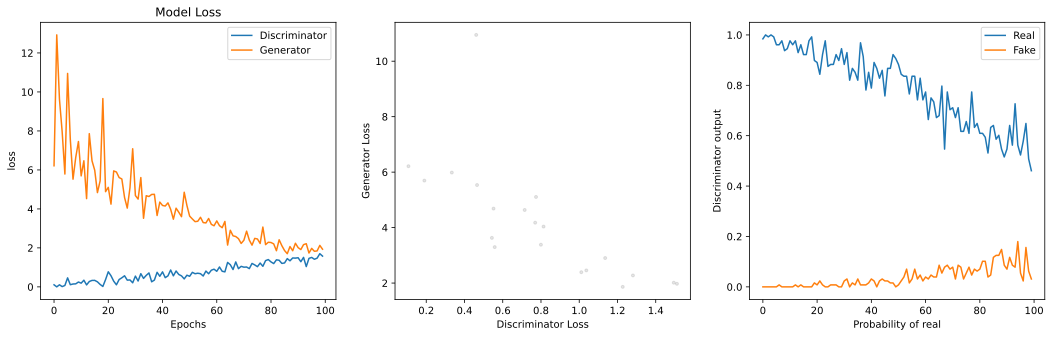

In [159]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(discrAccuracy)
ax[2].set_xlabel('Epochs')
ax[2].set_xlabel('Probability of real')
ax[2].set_ylabel('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

In [293]:
# eval mode
genModel.eval()

# generate images using the GAN network
fakeData = genModel( torch.randn(32,64).to(device) ).cpu()
fakeData = fakeData / 2 + 0.5 #undo normalization

#visualize
fig,axs = plt.subplots(4,8,figsize=(8,4))
for i,ax in enumerate(axs.flatten()):
    img = fakeData[i].detach().view(32,32,3).numpy()
    ax.imshow(img)
    ax.axis('off')
    
plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [32, 64]